This will adapt structure window size

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, matthews_corrcoef, accuracy_score, balanced_accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
import random

In [2]:
# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.keras.utils.set_random_seed(SEED)  # This sets all random seeds in keras
tf.config.experimental.enable_op_determinism()  # For complete reproducibility

In [3]:
def prepare_structure_data(df):
    """Enhanced feature preparation focusing on important features"""
    features_list = []
    middle_pos = 16  # Center position
    
    # Helper function for normalization
    def normalize_angles(angle_array):
        angle_rad = np.pi * angle_array / 180.0
        return np.stack([np.sin(angle_rad), np.cos(angle_rad)], axis=-1)
    
    # 1. Most important features (importance > 0.04) - using ±0 window
    important_features = [
        'bfactor',
        'distance_to_center',
        'sasa',
        'omega',
        'domain_position'
    ]
    
    for feature in important_features:
        feature_arrays = np.array([np.array(eval(x)) for x in df[feature]])
        # Take only the center position
        center_values = feature_arrays[:, middle_pos]
        scaler = RobustScaler()
        scaled_values = scaler.fit_transform(center_values.reshape(-1, 1))
        features_list.append(scaled_values)
    
    # 2. Secondary important features (0.03 < importance < 0.04)
    secondary_features = [
        'chi1', 'chi2', 'chi3', 'chi4',
        'curvature', 'psi', 'phi', 'tau',
        'packing_density', 'local_hydrophobicity'
    ]
    
    for feature in secondary_features:
        feature_arrays = np.array([np.array(eval(x)) for x in df[feature]])
        center_values = feature_arrays[:, middle_pos]
        if feature in ['phi', 'psi', 'omega', 'tau']:
            # Angle features get sin/cos encoding
            angle_features = normalize_angles(center_values)
            features_list.append(angle_features)
        else:
            scaler = RobustScaler()
            scaled_values = scaler.fit_transform(center_values.reshape(-1, 1))
            features_list.append(scaled_values)
    
    # 3. Special case: hydrophobicity with ±1 window
    hydro_arrays = np.array([np.array(eval(x)) for x in df['hydrophobicity']])
    hydro_window = hydro_arrays[:, middle_pos-1:middle_pos+2]  # ±1 window
    scaler = RobustScaler()
    hydro_scaled = scaler.fit_transform(hydro_window.reshape(-1, 1)).reshape(len(hydro_arrays), 3)
    features_list.append(hydro_scaled)
    
    # Combine all features
    features = np.concatenate(features_list, axis=-1)
    
    # Add a dimension for the "sequence" length (1 for center position)
    features = features.reshape(features.shape[0], 1, -1)
    
    return features

In [10]:
def create_structure_only_model(struct_features, struct_window=0):
    """Create model with only structure track"""
    # Calculate actual window size for structure
    struct_positions = 1 + (2 * struct_window)
    
    # Structure track
    struct_input = tf.keras.layers.Input(shape=(1, struct_features), name='structure_input')
    
    # Dense layers instead of Conv1D since we only have one position
    x = tf.keras.layers.Flatten()(struct_input)
    
    # Multiple dense layers
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    
    # Output layer
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs=struct_input, outputs=outputs)
    return model

In [8]:
def train_and_evaluate_structure(struct_window=0):
    """Training function for structure-only model"""
    # Load data
    print("Loading data...")
    train_df = pd.read_csv("../data/processed_features_train_latest.csv")
    test_df = pd.read_csv("../data/processed_features_test_latest.csv")
    
    # Prepare data
    X_train_struct = prepare_structure_data(train_df)
    X_test_struct = prepare_structure_data(test_df)
    
    y_train = train_df['label'].values
    y_test = test_df['label'].values
    
    # Print data shapes
    print("\nData shapes:")
    print(f"X_train_struct: {X_train_struct.shape}")
    print(f"X_test_struct: {X_test_struct.shape}")
    print(f"y_train: {y_train.shape}")
    print(f"y_test: {y_test.shape}")
    
    # Calculate class weights
    total_samples = len(y_train)
    pos_samples = np.sum(y_train == 1)
    neg_samples = np.sum(y_train == 0)
    
    class_weights = {
        0: total_samples / (2 * neg_samples),
        1: total_samples / (2 * pos_samples)
    }
    
    # Cross-validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    metrics = {'acc': [], 'balanced_acc': [], 'mcc': [], 'sn': [], 'sp': []}
    test_predictions = []
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train_struct), 1):
        print(f"\nFold {fold}/5")
        
        # Callbacks
        callbacks = [
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=5,
                restore_best_weights=True
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=3,
                min_lr=1e-6
            )
        ]
        
        # Create and compile model
        model = create_structure_only_model(
            struct_features=X_train_struct.shape[2],
            struct_window=struct_window
        )
        
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        
        # Train model
        history = model.fit(
            X_train_struct[train_idx],
            y_train[train_idx],
            validation_data=(X_train_struct[val_idx], y_train[val_idx]),
            batch_size=32,
            epochs=50,
            callbacks=callbacks,
            class_weight=class_weights,
            verbose=1
        )
        
        # Plot training history
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title(f'Model Accuracy - Fold {fold}')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()
        
        # Evaluate on validation set
        y_pred = model.predict(X_train_struct[val_idx])
        y_pred_binary = (y_pred > 0.5).astype(int)
        
        # Calculate metrics
        cm = confusion_matrix(y_train[val_idx], y_pred_binary)
        metrics['acc'].append(accuracy_score(y_train[val_idx], y_pred_binary))
        metrics['balanced_acc'].append(balanced_accuracy_score(y_train[val_idx], y_pred_binary))
        metrics['mcc'].append(matthews_corrcoef(y_train[val_idx], y_pred_binary))
        metrics['sn'].append(cm[1][1]/(cm[1][1]+cm[1][0]))  # Sensitivity
        metrics['sp'].append(cm[0][0]/(cm[0][0]+cm[0][1]))  # Specificity
        
        # Predict on test set
        test_pred = model.predict(X_test_struct)
        test_predictions.append(test_pred)
        
        # Print fold results
        print(f"\nFold {fold} Results:")
        print(f"Accuracy: {metrics['acc'][-1]:.4f}")
        print(f"Balanced Accuracy: {metrics['balanced_acc'][-1]:.4f}")
        print(f"MCC: {metrics['mcc'][-1]:.4f}")
        print(f"Sensitivity: {metrics['sn'][-1]:.4f}")
        print(f"Specificity: {metrics['sp'][-1]:.4f}")
        
    # Print average cross-validation results
    print("\nAverage Cross-validation Results:")
    for metric in metrics:
        print(f"{metric.upper()}: {np.mean(metrics[metric]):.4f} ± {np.std(metrics[metric]):.4f}")
    
    # Ensemble predictions on test set
    test_pred_avg = np.mean(test_predictions, axis=0)
    test_pred_binary = (test_pred_avg > 0.5).astype(int)
    
    # Calculate final test metrics
    cm_test = confusion_matrix(y_test, test_pred_binary)
    
    print("\nFinal Test Set Results:")
    print(f"Accuracy: {accuracy_score(y_test, test_pred_binary):.4f}")
    print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, test_pred_binary):.4f}")
    print(f"MCC: {matthews_corrcoef(y_test, test_pred_binary):.4f}")
    print(f"Sensitivity: {cm_test[1][1]/(cm_test[1][1]+cm_test[1][0]):.4f}")
    print(f"Specificity: {cm_test[0][0]/(cm_test[0][0]+cm_test[0][1]):.4f}")
    print("Confusion Matrix:")
    print(cm_test)
        
    return model

Loading data...

Data shapes:
X_train_struct: (8850, 1, 21)
X_test_struct: (2737, 1, 21)
y_train: (8850,)
y_test: (2737,)

Fold 1/5
Epoch 1/50


2024-12-11 14:00:18.951139: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.5519 - loss: 0.7671 - val_accuracy: 0.6113 - val_loss: 0.6539 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.5923 - loss: 0.6821 - val_accuracy: 0.6136 - val_loss: 0.6477 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.6201 - loss: 0.6580 - val_accuracy: 0.6147 - val_loss: 0.6457 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.6178 - loss: 0.6543 - val_accuracy: 0.6215 - val_loss: 0.6454 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.6290 - loss: 0.6463 - val_accuracy: 0.6209 - val_loss: 0.6416 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.6319 - loss: 0.6400 - val_accuracy: 0.6175 - val_loss: 0.6416 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.6516 - loss: 0.6352 - val_

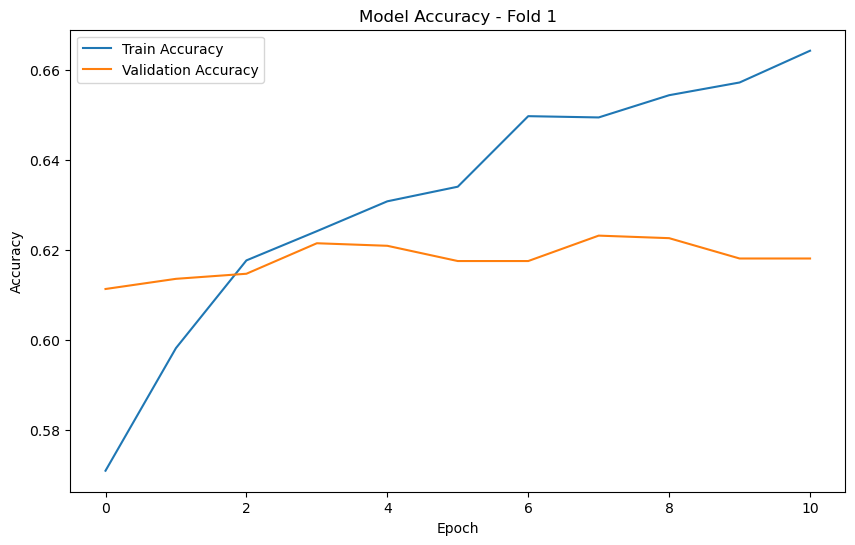

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Fold 1 Results:
Accuracy: 0.6175
Balanced Accuracy: 0.6166
MCC: 0.2336
Sensitivity: 0.6462
Specificity: 0.5869

Fold 2/5
Epoch 1/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.5439 - loss: 0.7811 - val_accuracy: 0.6282 - val_loss: 0.6525 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.6059 - loss: 0.6803 - val_accuracy: 0.6407 - val_loss: 0.6423 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.6176 - loss: 0.6652 - val_accuracy: 0.6390 - val_loss: 0.6413 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.6080 - loss: 0.6560 - val_accuracy: 0.6446 - val_loss: 0.6356 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.6395 - loss: 0.6372 - val_accuracy: 0.6395 - val_loss: 0.6357 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━

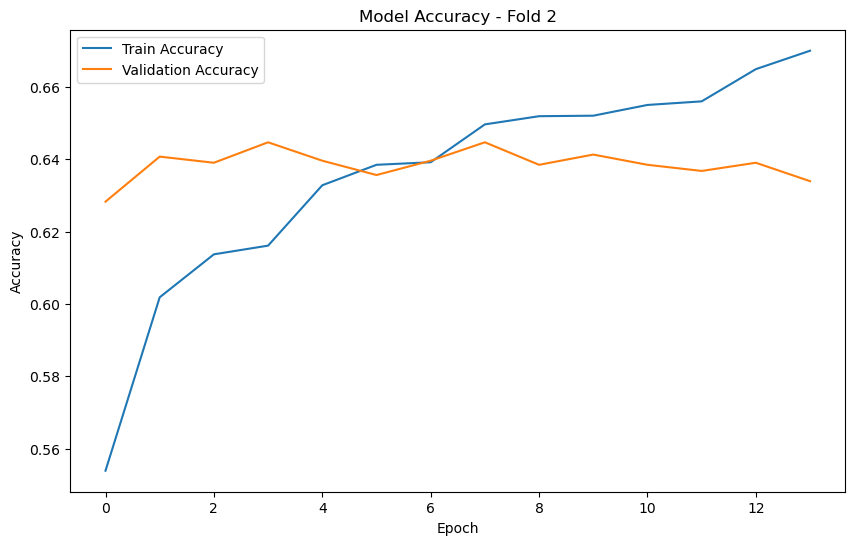

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Fold 2 Results:
Accuracy: 0.6384
Balanced Accuracy: 0.6339
MCC: 0.2714
Sensitivity: 0.7126
Specificity: 0.5552

Fold 3/5
Epoch 1/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.5631 - loss: 0.7469 - val_accuracy: 0.6169 - val_loss: 0.6588 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.6033 - loss: 0.6738 - val_accuracy: 0.6209 - val_loss: 0.6476 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.6083 - loss: 0.6611 - val_accuracy: 0.6379 - val_loss: 0.6420 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.6349 - loss: 0.6390 - val_accuracy: 0.6350 - val_loss: 0.6417 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.6367 - loss: 0.6353 - val_accuracy: 0.6401 - val_loss: 0.6432 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━

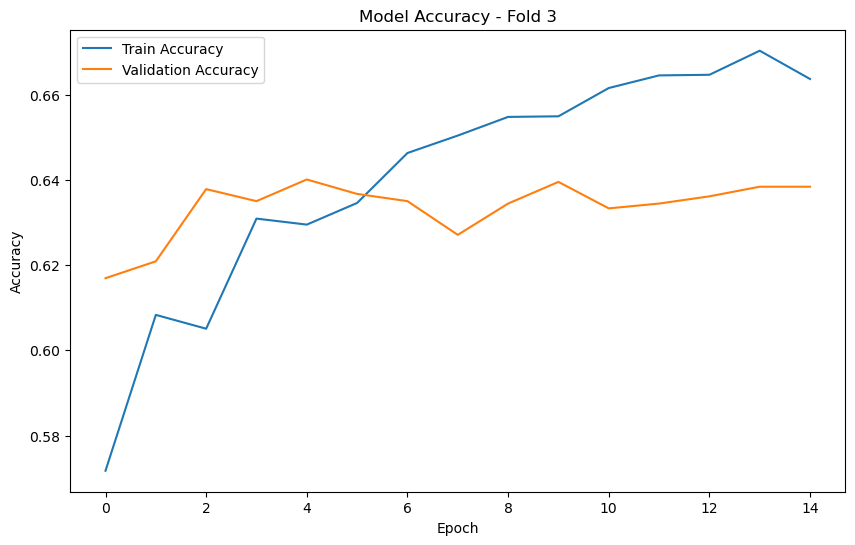

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Fold 3 Results:
Accuracy: 0.6395
Balanced Accuracy: 0.6372
MCC: 0.2777
Sensitivity: 0.7108
Specificity: 0.5636

Fold 4/5
Epoch 1/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.5566 - loss: 0.7611 - val_accuracy: 0.6158 - val_loss: 0.6556 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6062 - loss: 0.6672 - val_accuracy: 0.6237 - val_loss: 0.6444 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.6335 - loss: 0.6484 - val_accuracy: 0.6322 - val_loss: 0.6423 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.6364 - loss: 0.6451 - val_accuracy: 0.6282 - val_loss: 0.6421 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.6382 - loss: 0.6394 - val_accuracy: 0.6379 - val_loss: 0.6359 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━

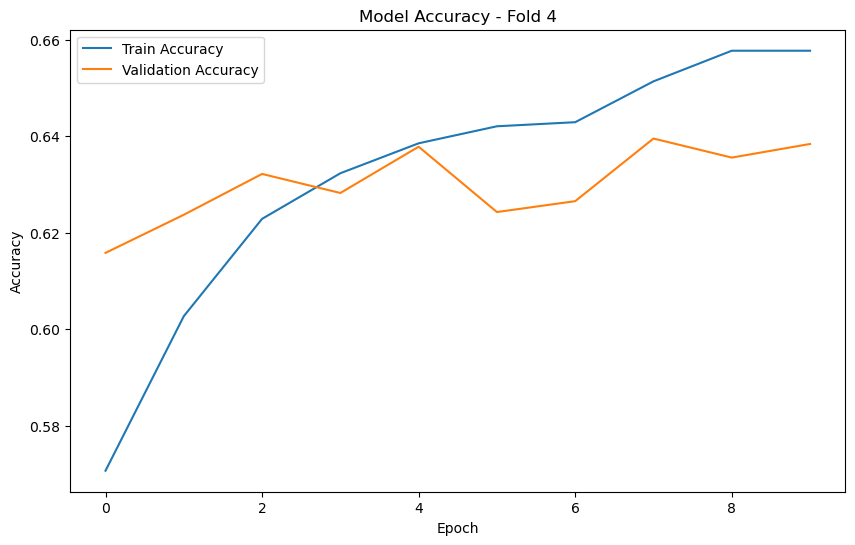

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Fold 4 Results:
Accuracy: 0.6379
Balanced Accuracy: 0.6355
MCC: 0.2743
Sensitivity: 0.7087
Specificity: 0.5624

Fold 5/5
Epoch 1/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.5534 - loss: 0.7432 - val_accuracy: 0.6254 - val_loss: 0.6588 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.6148 - loss: 0.6680 - val_accuracy: 0.6288 - val_loss: 0.6529 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.6287 - loss: 0.6472 - val_accuracy: 0.6305 - val_loss: 0.6526 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.6346 - loss: 0.6435 - val_accuracy: 0.6254 - val_loss: 0.6494 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.6484 - loss: 0.6390 - val_accuracy: 0.6362 - val_loss: 0.6483 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━

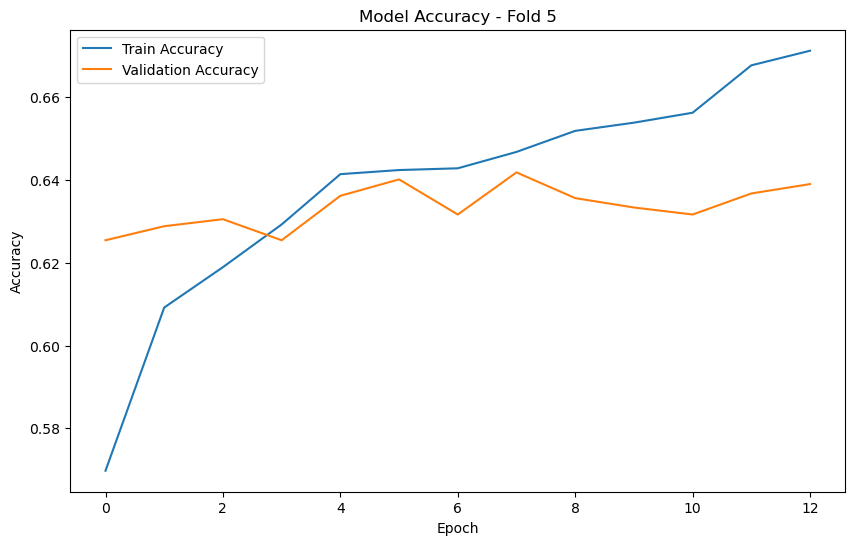

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Fold 5 Results:
Accuracy: 0.6418
Balanced Accuracy: 0.6392
MCC: 0.2816
Sensitivity: 0.7121
Specificity: 0.5662

Average Cross-validation Results:
ACC: 0.6350 ± 0.0089
BALANCED_ACC: 0.6325 ± 0.0081
MCC: 0.2677 ± 0.0174
SN: 0.6981 ± 0.0260
SP: 0.5669 ± 0.0107

Final Test Set Results:
Accuracy: 0.4900
Balanced Accuracy: 0.6075
MCC: 0.1223
Sensitivity: 0.7500
Specificity: 0.4650
Confusion Matrix:
[[1161 1336]
 [  60  180]]


In [11]:
if __name__ == "__main__":
    model = train_and_evaluate_structure()